In [74]:
# !pip install -U scikit-learn pandas xgboost openpyxl
# !pip uninstall -y torch torchvision torchaudio transformers sentence-transformers
# !pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --extra-index-url https://download.pytorch.org/whl/cu118
# !pip install transformers==4.35.2
# !pip install sentence-transformers==2.2.2
# !pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --extra-index-url https://download.pytorch.org/whl/cu118
# !pip install transformers==4.35.2 sentence-transformers==2.2.2 huggingface_hub==0.16.4
# !pip install matplotlib
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [20]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
import joblib

In [8]:
dataset  =  pd.read_excel('data_for_hvp_rankings.xlsx')

In [54]:
traits = ['VQ A 6', 'VQ B 9', 'VQ C 10', 'VQ D 11',
       'VQ E 13', 'VQ F 5', 'VQ G 17', 'VQ H 16', 'VQ I 12', 'VQ J 4',
       'VQ K 1', 'VQ L 18', 'VQ M 2', 'VQ N 14', 'VQ O 8', 'VQ P 15', 'VQ Q 3',
       'VQ R 7', 'SQ A 6', 'SQ B 9', 'SQ C 10', 'SQ D 11', 'SQ E 13', 'SQ F 5',
       'SQ G 17', 'SQ H 16', 'SQ I 12', 'SQ J 4', 'SQ K 1', 'SQ L 18',
       'SQ M 2', 'SQ N 14', 'SQ O 8', 'SQ P 15', 'SQ Q 3', 'SQ R 7']

In [55]:
X = dataset["Message"]
y = dataset[traits]

In [11]:
sbert = SentenceTransformer("all-mpnet-base-v2")

In [12]:
embedded_sequences = []

for txt in tqdm(X, desc="Encoding Messages"):
    
    embeddings = sbert.encode(txt, convert_to_numpy=True)
    embedded_sequences.append(embeddings)

X_embedded = np.array(embedded_sequences)

Encoding Messages: 100%|██████████| 667/667 [00:19<00:00, 33.64it/s]


In [27]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

def train_xgboost_pipeline(X, y):

    xgb = MultiOutputRegressor(
        XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="reg:squarederror",
            tree_method="hist",
            n_jobs=-1
        )
    )
    xgb.fit(X, y)
    joblib.dump(xgb, "xgb_pipeline.pkl")
    print("Model saved as xgb_pipeline.pkl")
    return xgb


In [31]:
from sentence_transformers import SentenceTransformer
import numpy as np

def predict_traits(text_list, model):
    embeddings = sbert.encode(text_list, convert_to_numpy=True)
    return model.predict(embeddings)


In [33]:
# model = train_xgboost_pipeline(X_embedded,y)

In [34]:
model = joblib.load("xgb_pipeline.pkl")

In [35]:
pred = predict_traits(["This is a sample text"],model)
print(pred)

[[ 5.978582   7.194061  11.529153  11.253067  12.621037   5.2490273
  15.543749  15.315439  11.59032    3.7821455  5.1231003 16.810272
   4.451249  13.662497  11.0444355 12.781088   5.9716644  5.0302176
   5.087674   6.4149995 12.745345   9.360579  12.536142   7.9301124
  14.488624  14.01436   11.243235   9.185996   7.214943  12.92785
   7.914913  11.565537   7.4232025 11.890482   5.764753   7.840245 ]]


In [37]:
y_pred = model.predict(X_embedded)


In [38]:
r2_score(y,y_pred)

0.9431005120277405

In [40]:
from sklearn.metrics import r2_score, mean_absolute_error

print("R²:", r2_score(y, y_pred, multioutput='uniform_average'))
print("MAE:", mean_absolute_error(y, y_pred, multioutput='uniform_average'))


R²: 0.9431005120277405
MAE: 0.2509634792804718


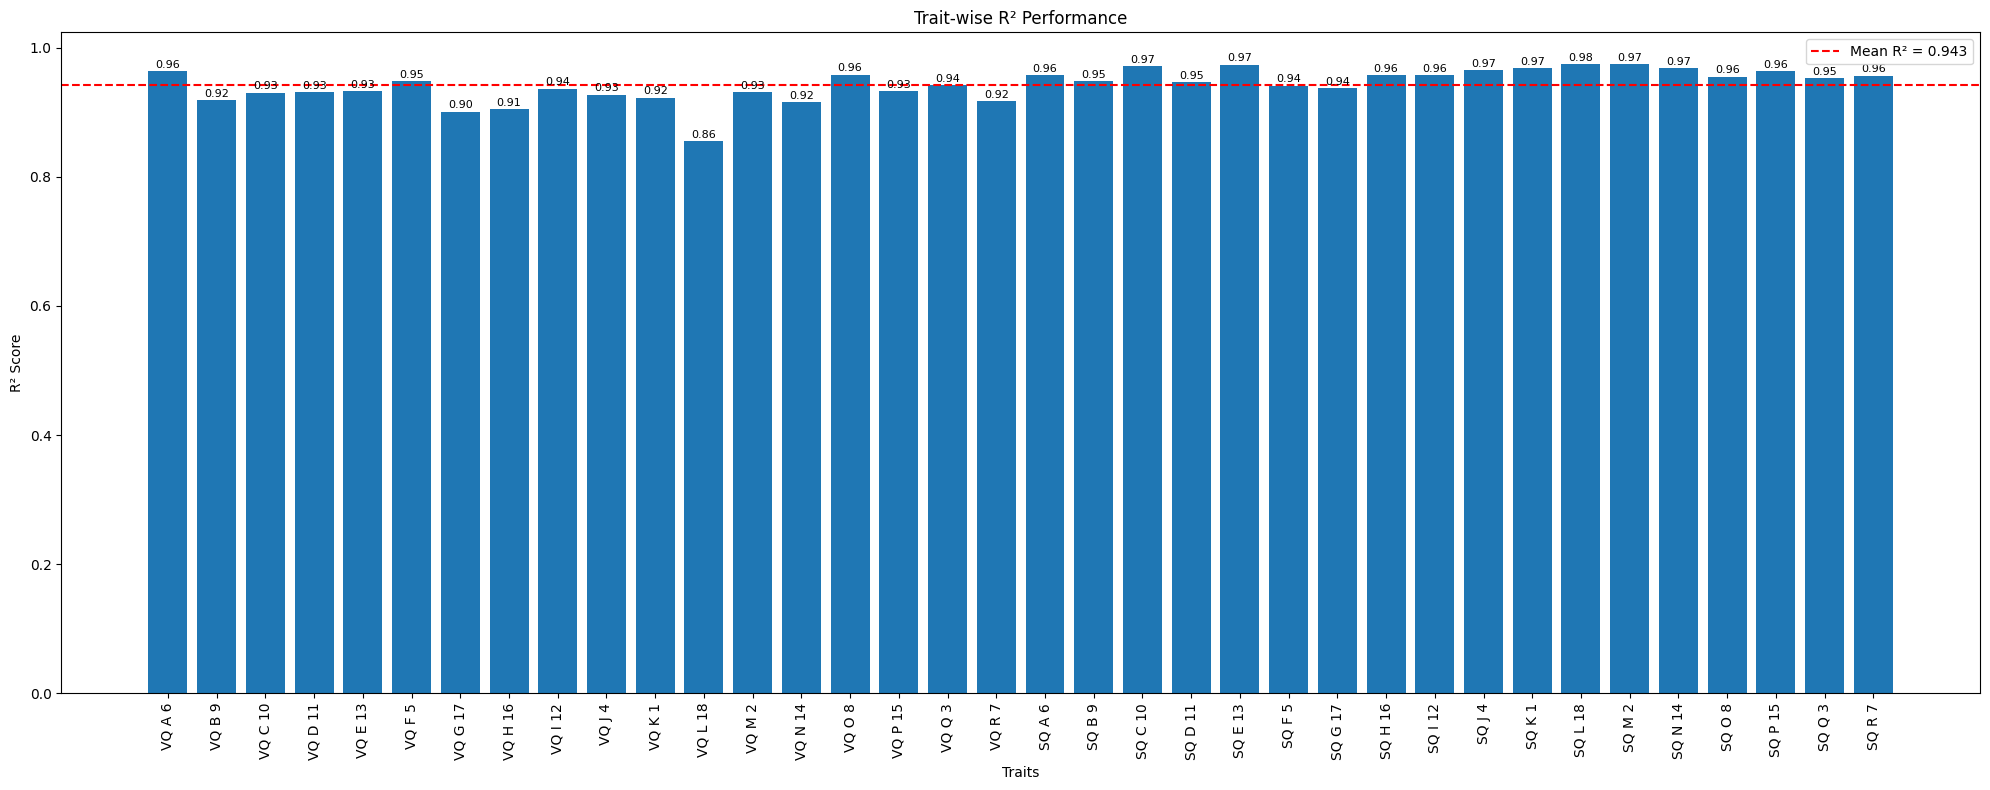

<Figure size 640x480 with 0 Axes>

In [64]:
# Compute R² per trait
r2_scores = [r2_score(y[:, i], y_pred[:, i]) for i in range(y.shape[1])]
mean_r2 = np.mean(r2_scores)

plt.figure(figsize=(20,8))  # wide but not crazy wide
plt.bar(traits, r2_scores)

# Mean line
plt.axhline(mean_r2, color='red', linestyle='--', label=f"Mean R² = {mean_r2:.3f}")

plt.xlabel("Traits")
plt.ylabel("R² Score")
plt.title("Trait-wise R² Performance")

# Rotate X labels so they don't overlap
plt.xticks(rotation=90)

# Add score above bars
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=8)

plt.tight_layout()
plt.legend()
plt.show()
plt.savefig("Trait-wise-r2Score.png", dpi=300, bbox_inches="tight")


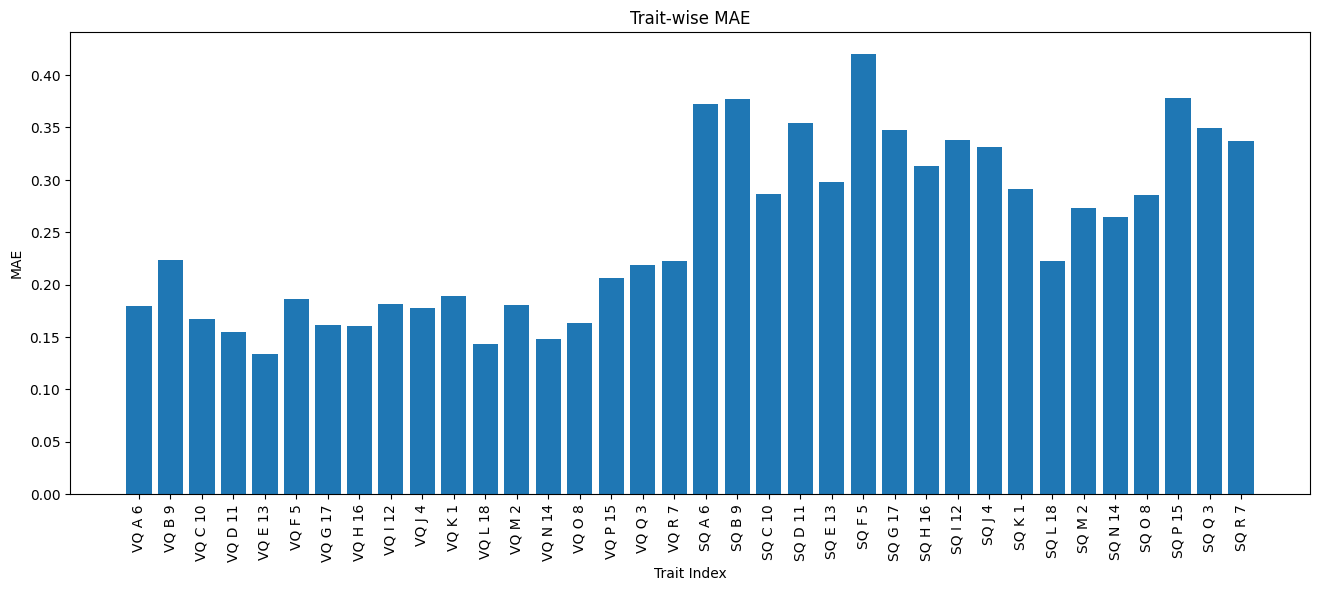

<Figure size 640x480 with 0 Axes>

In [63]:
from sklearn.metrics import mean_absolute_error

mae_scores = [mean_absolute_error(y[:, i], y_pred[:, i]) for i in range(36)]

plt.figure(figsize=(16,6))
plt.bar(traits, mae_scores)
plt.xlabel("Trait Index")
plt.xticks(rotation=90)
plt.ylabel("MAE")
plt.title("Trait-wise MAE")
plt.show()
plt.savefig("Trait-wise-mae.png", dpi=300, bbox_inches="tight")


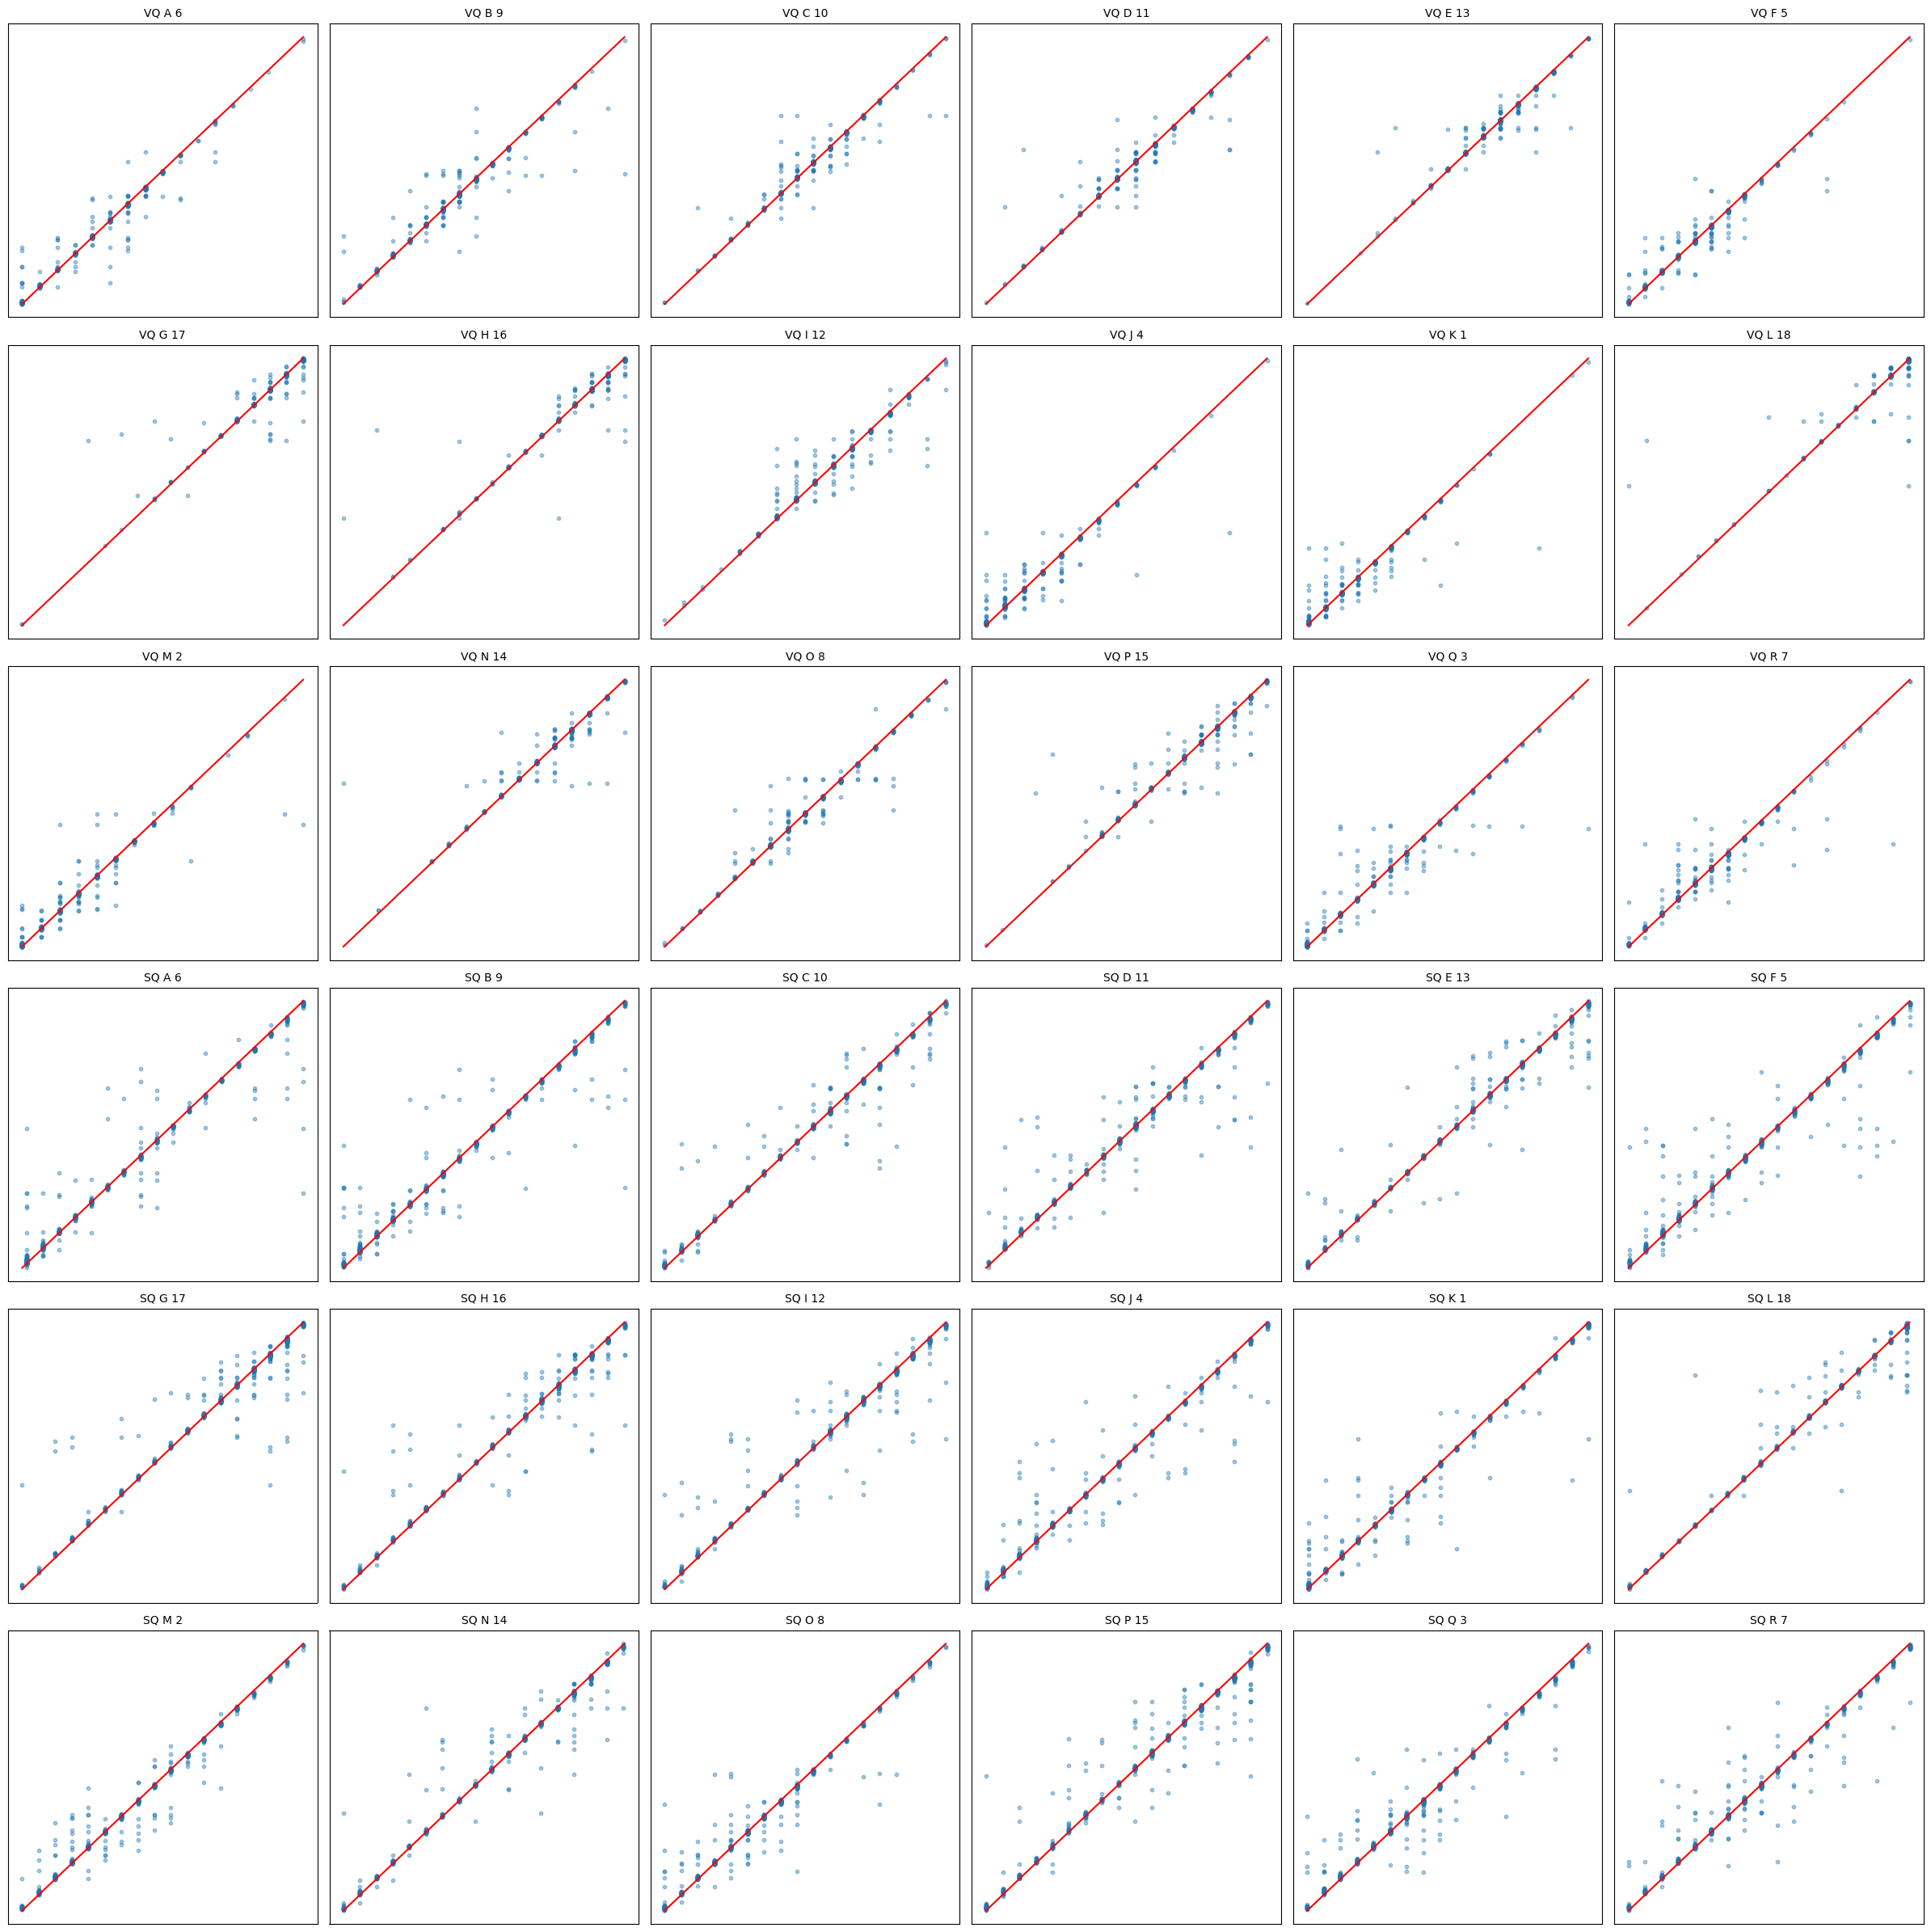

<Figure size 640x480 with 0 Axes>

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Ensure arrays
y = np.asarray(y)
y_pred = np.asarray(y_pred)

num_traits = y.shape[1]

plt.figure(figsize=(24, 24))   # big figure for clarity

for i in range(num_traits):
    plt.subplot(6, 6, i+1)
    plt.scatter(y[:, i], y_pred[:, i], alpha=0.4, s=10)

    # perfect fit line
    min_val = min(y[:, i].min(), y_pred[:, i].min())
    max_val = max(y[:, i].max(), y_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red')

    # title with trait name if available
    if 'traits' in globals():
        plt.title(traits[i], fontsize=10)
    else:
        plt.title(f"Trait {i}", fontsize=10)

    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()
plt.savefig("BestFitAllRankings.png", dpi=300, bbox_inches="tight")


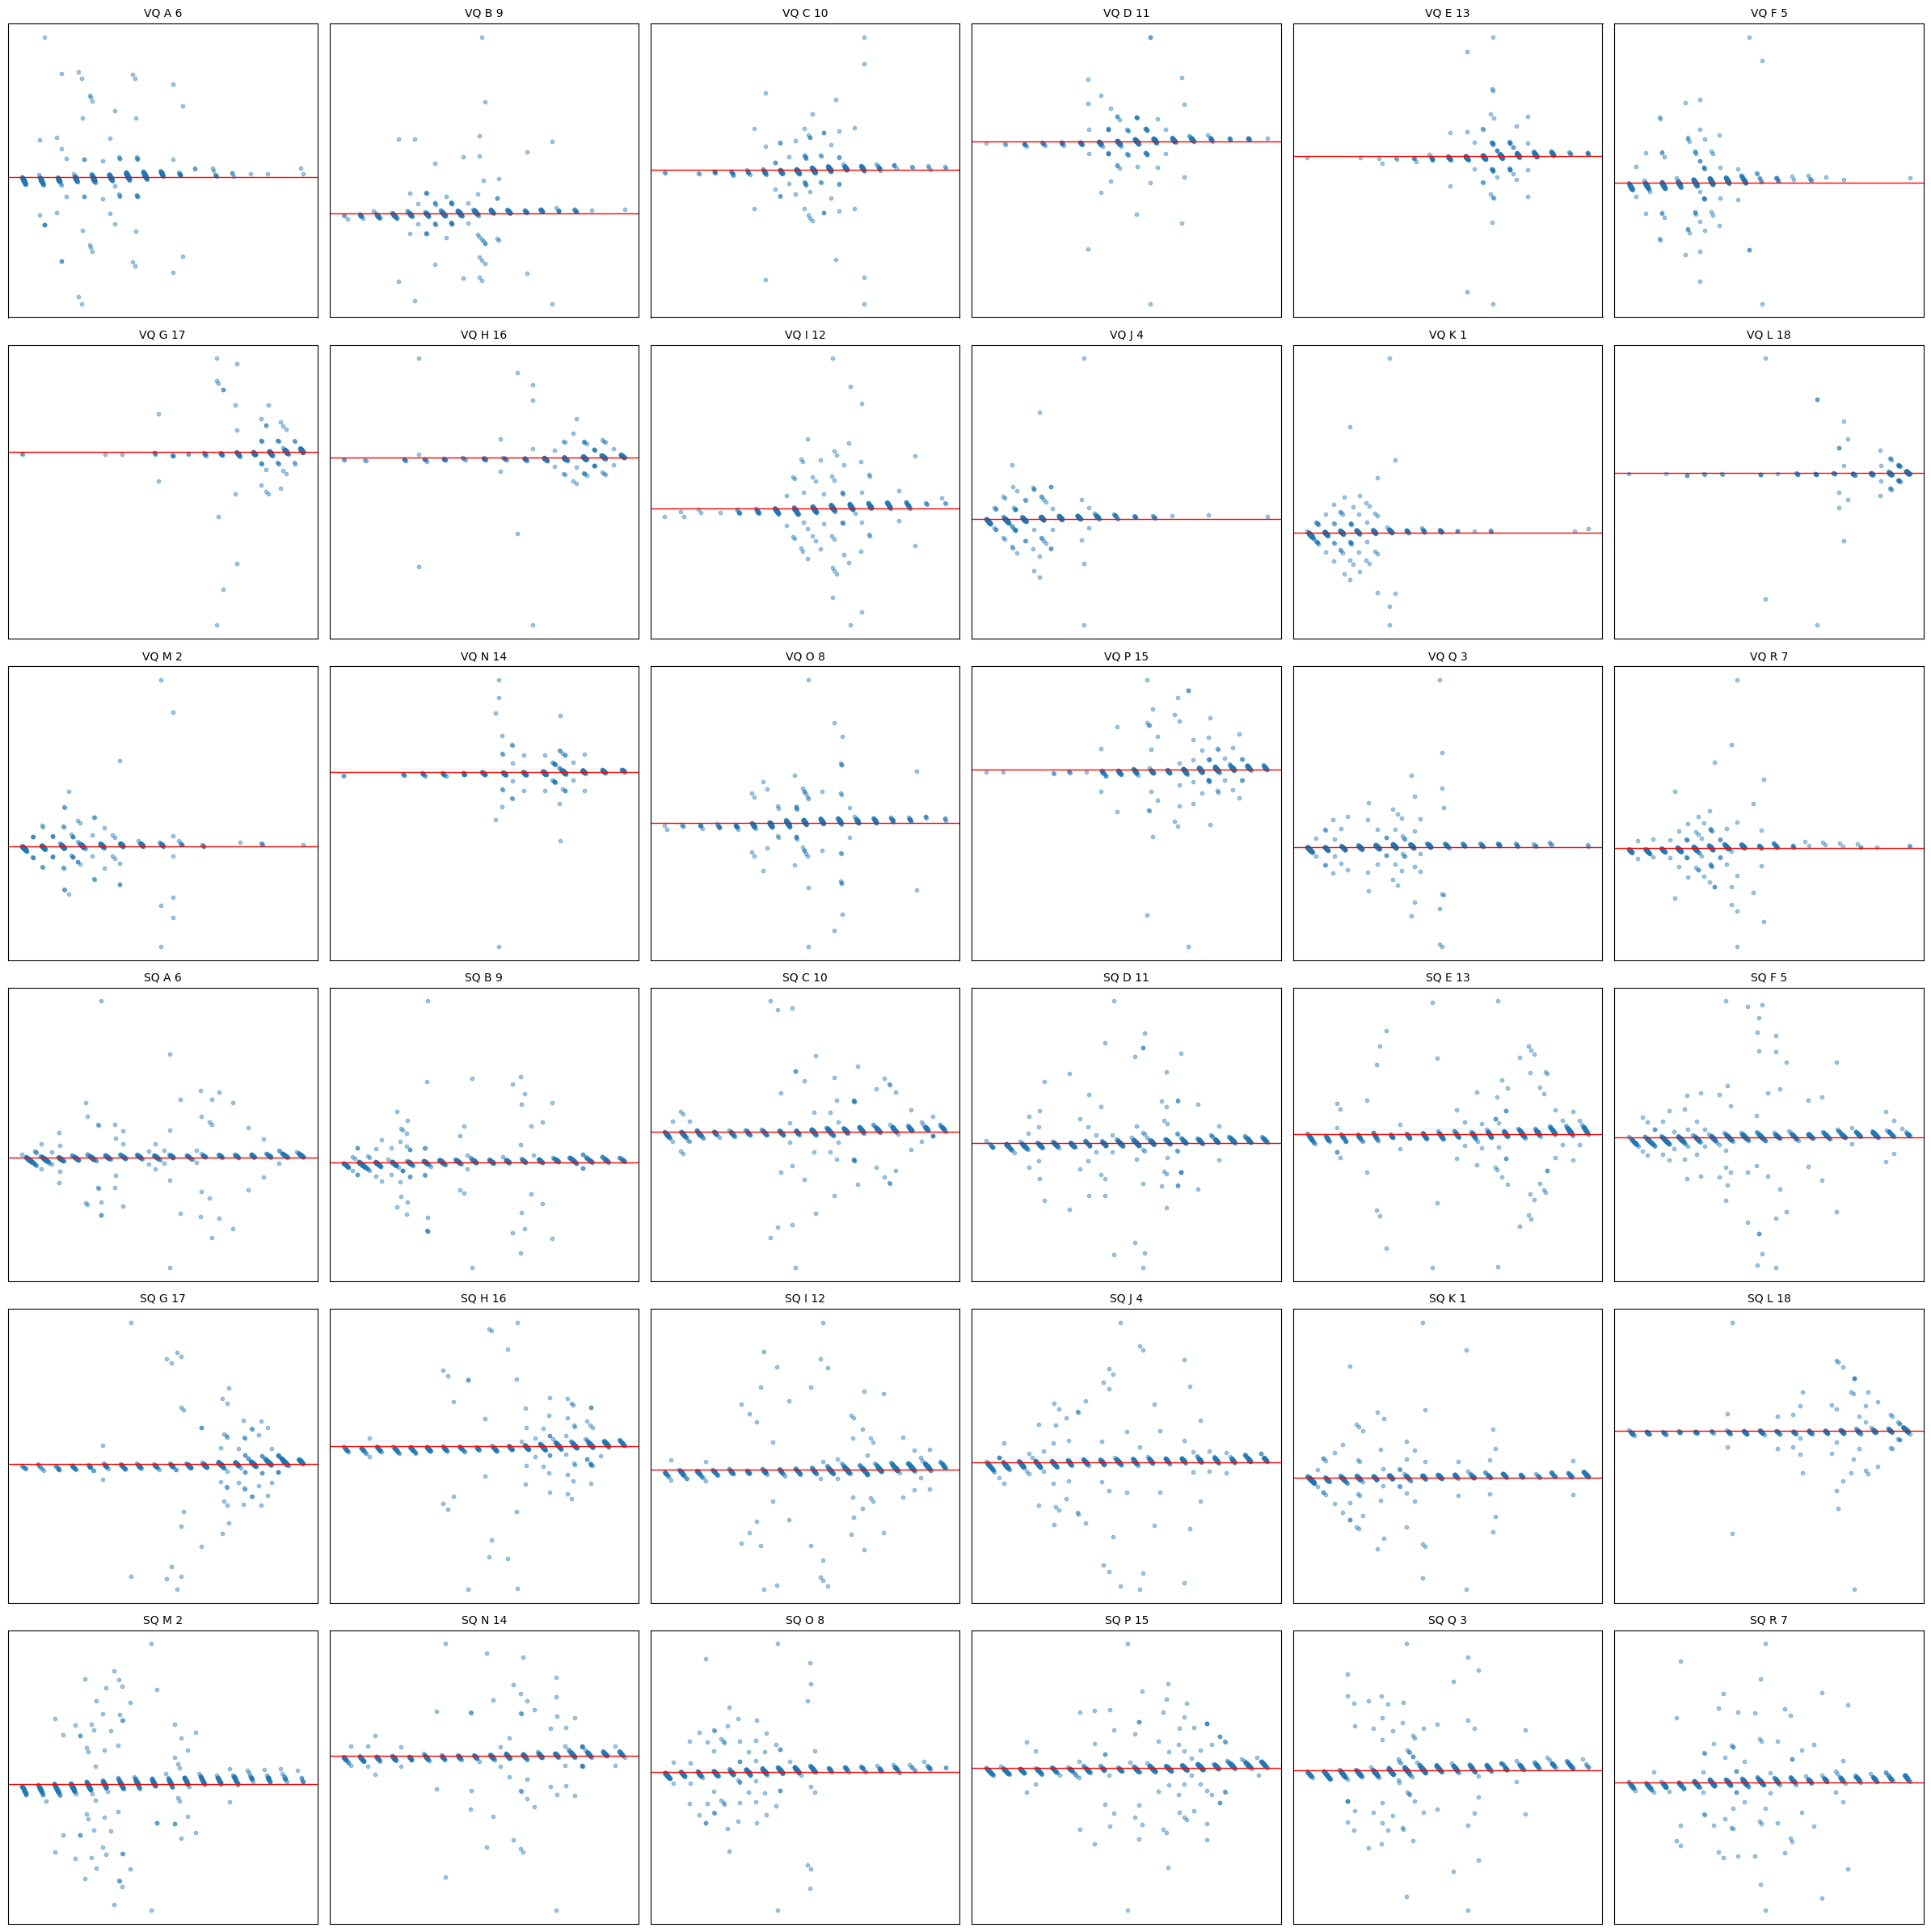

<Figure size 640x480 with 0 Axes>

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure numpy arrays
y = np.asarray(y)
y_pred = np.asarray(y_pred)

num_traits = y.shape[1]

plt.figure(figsize=(24, 24))

for i in range(num_traits):
    errors = y[:, i] - y_pred[:, i]

    plt.subplot(6, 6, i+1)
    plt.scatter(y_pred[:, i], errors, alpha=0.4, s=10)
    plt.axhline(0, color='red', linewidth=1)

    # Title with trait name if available
    if 'traits' in globals():
        plt.title(traits[i], fontsize=10)
    else:
        plt.title(f"Trait {i}", fontsize=10)

    # cleaner look
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

plt.savefig("ResidualAllRankings.png", dpi=300, bbox_inches="tight")

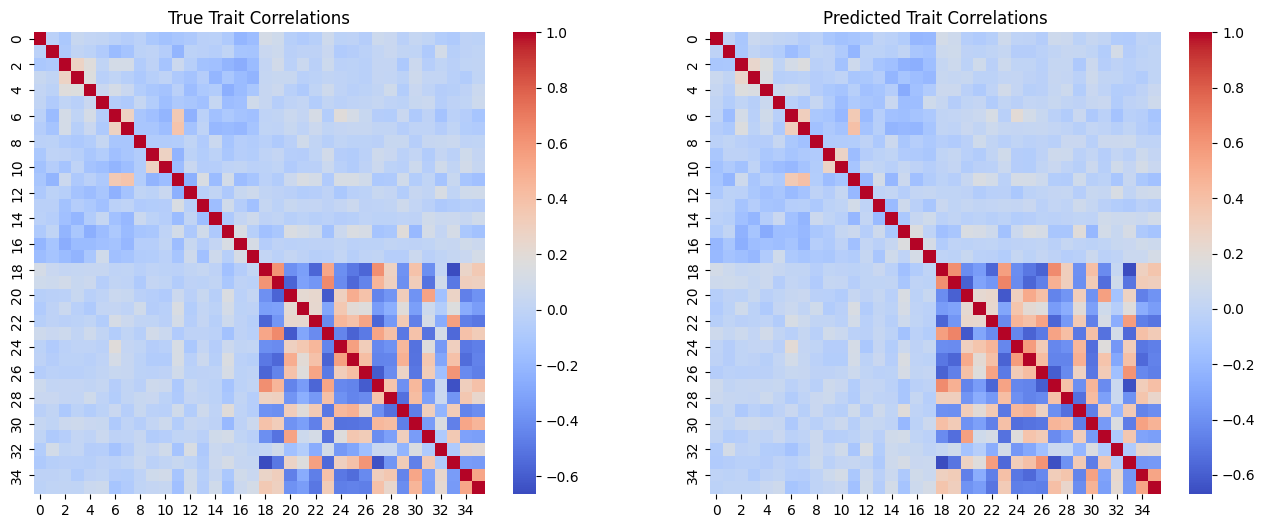

<Figure size 640x480 with 0 Axes>

In [77]:
import seaborn as sns
import numpy as np

corr_true = np.corrcoef(y.T)
corr_pred = np.corrcoef(y_pred.T)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.heatmap(corr_true, cmap='coolwarm')
plt.title("True Trait Correlations")

plt.subplot(1,2,2)
sns.heatmap(corr_pred, cmap='coolwarm')
plt.title("Predicted Trait Correlations")

plt.show()
plt.savefig("TruevsPredictedCorrelation.png", dpi=300, bbox_inches="tight")

In [81]:
import pandas as pd

df_results = pd.DataFrame({
    "Trait": traits,
    "R²": r2_scores,
    "MAE": mae_scores
})

df_results.to_excel('Report-R2-and-Mae-TraitWise.xlsx')